In [24]:
import pandas as pd
import hdbscan
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
import umap
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
import os
import openai
import pandas as pd
from openai import OpenAI
from IPython.display import display, Markdown

In [12]:
exhibitors_df = pd.read_csv("/content/cleaned_exhibitors_df.csv")
visitors_df = pd.read_csv("/content/cleaned_visitors_df.csv")

**EXIBHITOR CLUSTER ANALYSIS**

In [17]:
# Load pre-trained BERT-based model for embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings for Maincategories
category_embeddings = model.encode(exhibitors_df['MainCategories'].tolist(), normalize_embeddings=True)

# Convert to NumPy array for clustering
category_embeddings = np.array(category_embeddings)

umap_model = umap.UMAP(n_neighbors=10, min_dist=0.05, n_components=2)
reduced_embeddings = umap_model.fit_transform(category_embeddings)

#clustering
clusterer = hdbscan.HDBSCAN(min_cluster_size=6, min_samples=5, metric='euclidean', cluster_selection_method='eom')
cluster_labels = clusterer.fit_predict(reduced_embeddings)

# Add the new cluster labels to the DataFrame
exhibitors_df['Cluster'] = cluster_labels

if len(set(cluster_labels)) > 1:
    silhouette_avg = silhouette_score(reduced_embeddings, cluster_labels)
    print(f'Silhouette Score: {silhouette_avg:.4f}')
else:
    print("Clusters are not well-formed. Try adjusting parameters.")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Silhouette Score: 0.7286


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [18]:
for cluster_id in sorted(exhibitors_df['Cluster'].unique()):
    print(f"\nCluster {cluster_id}:\n" + "-"*40)
    cluster_data = exhibitors_df[exhibitors_df['Cluster'] == cluster_id][['MainCategories']]

    for _, row in cluster_data.iterrows():
        print(f"{row['MainCategories']}")



Cluster -1:
----------------------------------------
boarding house
boarding house
mice and event management
boarding house
airlines
mice and event management
mice agency
mice agency
event organizer

Cluster 0:
----------------------------------------
nto: national tourism office
regional tourism office
tic: travel information centre
data analytics and personalization
tourist board/government/nto
tic: travel information centre
tourist board/government/nto
nto: national tourism office
nto: national tourism office
data analytics and personalization
nto: national tourism office
nto: national tourism office

Cluster 1:
----------------------------------------
online media
vr and ar
print media
vr and ar
print media
radio and tv
radio and tv
vr and ar
print media
print media
radio and tv

Cluster 2:
----------------------------------------
other transport services
transfer services
other transport services
other transport services
payment service provider
payment service provider
payment s

In [19]:
#Display Clusters with Themes
def get_cluster_keywords(df, num_keywords=5):
    cluster_keywords = {}
    for cluster in df["Cluster"].unique():
        if cluster == -1:  # Ignore noise
            continue
        cluster_texts = df[df["Cluster"] == cluster]["MainCategories"].tolist()
        vectorizer = TfidfVectorizer(stop_words="english", max_features=1000)
        tfidf_matrix = vectorizer.fit_transform(cluster_texts)
        feature_array = np.array(vectorizer.get_feature_names_out())
        tfidf_sorting = np.argsort(tfidf_matrix.toarray().sum(axis=0))[::-1]
        top_keywords = feature_array[tfidf_sorting][:num_keywords]
        cluster_keywords[cluster] = ", ".join(top_keywords)
    return cluster_keywords

cluster_themes = get_cluster_keywords(exhibitors_df)


for cluster, keywords in cluster_themes.items():
    print(f"Cluster {cluster}: {keywords}")

Cluster 7: tourism, religious, resort, hotel, adventure
Cluster 3: tour, operator, specialized, inbound, operators
Cluster 11: motel, hostel, hotel, residential, apartments
Cluster 15: travel, agency, agencies, authorized, independent
Cluster 16: travel, search, aggregator, engine, online
Cluster 2: services, transport, service, payment, provider
Cluster 9: services, helicopter, facilities
Cluster 10: hotel, inn, chain, equipment, suppliers
Cluster 8: tourism, gastro, industrial, type, specialized
Cluster 1: media, print, vr, radio, tv
Cluster 13: museum, museums, parks, site, heritage
Cluster 4: company, insurance, management, banking, investments
Cluster 0: nto, office, tourism, national, analytics
Cluster 12: motorhomes, mobile, caravans, app, glampings
Cluster 14: zoo, park, national, water, theme
Cluster 5: hospitals, clinics, short, services, term
Cluster 6: manufacturer, distributor, industry, association, machinery


In [25]:
#generate cluster themes using LLM

client = OpenAI(api_key=openai_api_key)

def generate_cluster_theme(categories):
    prompt = f"Given the following list of categories for exibhitors at events, please identify a short, precise theme (2-3 words) that best represents each group of exibhitors:\n\n{categories}\n\nProvide only the theme."

    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": "You are a helpful assistant that generates concise, precise themes for clusters."},
            {"role": "user", "content": prompt}
        ]
    )

    return response.choices[0].message.content.strip()


# Dictionary to store cluster themes
cluster_themes = {}

for cluster_id in sorted(exhibitors_df['Cluster'].unique()):
    cluster_data = exhibitors_df[exhibitors_df['Cluster'] == cluster_id]['MainCategories'].tolist()

    # Get the theme for the current cluster using GPT-4o-mini
    theme = generate_cluster_theme(cluster_data)
    cluster_themes[cluster_id] = theme

# Print out the generated themes for each cluster using Markdown for better display
for cluster_id, theme in cluster_themes.items():
    display(Markdown(f"**Cluster {cluster_id}:** {theme}"))


**Cluster -1:** Event Management

**Cluster 0:** Tourism Offices

**Cluster 1:** Media Innovations

**Cluster 2:** Transport and Payments

**Cluster 3:** Tour Operator Diversity

**Cluster 4:** Financial Services

**Cluster 5:** Healthcare Services

**Cluster 6:** Industry Manufacturers

**Cluster 7:** Diverse Tourism Options

**Cluster 8:** Tourism Specialties

**Cluster 9:** Helicopter Services

**Cluster 10:** Hospitality Services

**Cluster 11:** Accommodation Types

**Cluster 12:** Recreational Vehicles

**Cluster 13:** Cultural Institutions

**Cluster 14:** Wildlife Attractions

**Cluster 15:** Travel Services

**Cluster 16:** Travel Booking Solutions

In [26]:
exhibitors_df["Cluster_Theme"] = exhibitors_df["Cluster"].map(cluster_themes)

In [27]:
exhibitors_df.to_csv('exhibitors_themes.csv')

**VISITORS CLUSTER ANALYSIS**

In [84]:
# Load pre-trained BERT-based model for embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')

# Filter the DataFrame to get answers for the question "Please indicate your company's main area of business"
# we are clustering the visitors only based on company's main area of business. we don't conider the answers as it affects the clustering quality
question_id = "5c8a78336d41a10da4f73253" # question id for main area of business
visitor_answers = visitors_df[visitors_df['questionId'] == question_id].copy()


print(f"Number of visitors answering the question: {len(visitor_answers)}")

# Generate embeddings for these answers
visitor_embeddings = model.encode(visitor_answers['answer'].tolist(), normalize_embeddings=True)
visitor_embeddings = np.array(visitor_embeddings)


# Apply UMAP for dimensionality reduction
umap_model = umap.UMAP(n_neighbors=6, min_dist=0.05, n_components=2)
reduced_embeddings = umap_model.fit_transform(visitor_embeddings)

# Apply HDBSCAN clustering
clusterer = hdbscan.HDBSCAN(min_cluster_size=3, min_samples=4, metric='euclidean', cluster_selection_method='eom')
cluster_labels = clusterer.fit_predict(reduced_embeddings)

# Create a dictionary mapping from visitorId to cluster label.
visitor_cluster_mapping = dict(zip(visitor_answers['visitorId'].astype(str), cluster_labels))
print("Visitor Cluster Mapping:", visitor_cluster_mapping)

# Update the full visitors_df with the cluster labels based on visitorId.
if 'visitorId' in visitors_df.columns:
    visitors_df['visitorId'] = visitors_df['visitorId'].astype(str)
    visitors_df['Cluster'] = visitors_df['visitorId'].map(visitor_cluster_mapping)
else:
    visitors_df.index = visitors_df.index.astype(str)
    visitors_df['Cluster'] = visitors_df.index.map(visitor_cluster_mapping)

# Fill missing cluster labels for visitors who didn't answer the question with -1.
#visitors_df['Cluster'] = visitors_df['Cluster'].fillna(-1).astype(int)

if len(set(cluster_labels)) > 1:
    silhouette_avg = silhouette_score(reduced_embeddings, cluster_labels)
    print(f"Silhouette Score: {silhouette_avg:.4f}")
else:
    print("Clusters are not well-formed. Try adjusting parameters.")

print(visitors_df.head())


Number of visitors answering the question: 87


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Visitor Cluster Mapping: {'67b70a9f2d21f543a1096602': np.int64(2), '67ada1ee197e604dd2722d1b': np.int64(1), '67b44fef197e604dd2722d3d': np.int64(2), '67b45018197e604dd2722d3e': np.int64(2), '67b5f1392d21f543a10965f1': np.int64(0), '67b5e0f7774d9e718c7541db': np.int64(0), '67b45356197e604dd2722d43': np.int64(2), '67b47874197e604dd2722d6f': np.int64(0), '67b708f32d21f543a10965fa': np.int64(2), '67b46946197e604dd2722d5d': np.int64(2), '67b46049197e604dd2722d4a': np.int64(2), '67b46590197e604dd2722d5a': np.int64(2), '67b47714197e604dd2722d69': np.int64(2), '67b47738197e604dd2722d6b': np.int64(2), '67b484a9197e604dd2722d72': np.int64(1), '67b70e142d21f543a1096609': np.int64(0), '67b709442d21f543a10965fe': np.int64(2), '67b70c7a2d21f543a1096605': np.int64(2), '67b46415197e604dd2722d55': np.int64(2), '67bcb979966b8de398095c90': np.int64(2), 'fs2j657x3gpu9hs8v3vuvgz0': np.int64(2), 'xodwfemcnbuqzq632xnlrxt6': np.int64(1), 'fi1h2gygfcwed97ls0e0c31v': np.int64(2), 'xy1nr3sp1vp7r17vtxyg683k': np.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [85]:
cluster_labels

array([2, 1, 2, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 2, 1,
       2, 2, 0, 0, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 1, 0, 2, 2,
       2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 1, 0, 2, 2, 2, 0, 2, 1, 2, 2, 2, 0,
       0, 1, 1, 2, 2, 2, 2, 2, 0, 2, 0, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2])

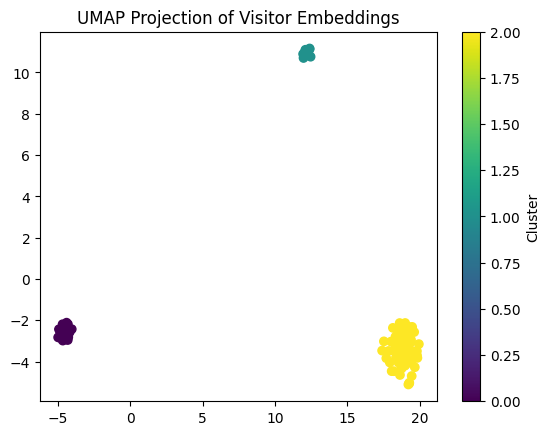

In [86]:
import matplotlib.pyplot as plt

# Visualize the reduced embeddings
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=cluster_labels, cmap='viridis')
plt.colorbar(label='Cluster')
plt.title('UMAP Projection of Visitor Embeddings')
plt.show()


In [87]:
for cluster_id in sorted(visitors_df['Cluster'].unique()):
    print(f"\nCluster {cluster_id}:\n" + "-"*40)

    cluster_data = visitors_df[(visitors_df['Cluster'] == cluster_id) & (visitors_df['questionId'] == question_id)][['answer']]

    # Print unique answers only for each cluster
    unique_answers = cluster_data['answer'].unique()
    for answer in unique_answers:
        print(answer)



Cluster 0.0:
----------------------------------------
Tour Operator

Cluster 1.0:
----------------------------------------
Event management

Cluster 2.0:
----------------------------------------
Travel Agent
IT solutions for travel industry
Accommodation Provider

Cluster nan:
----------------------------------------


In [88]:
import openai
import pandas as pd
from openai import OpenAI
from IPython.display import display, Markdown

# Initialize OpenAI client
client = OpenAI(api_key=openai_api_key)

def generate_cluster_theme(categories):
    # Join the list of categories into a string for the prompt
    prompt = f"Given the following list of responses for a specific question, please identify a short, precise theme (2-3 words) that best represents each group of responses:\n\n{categories}\n\nProvide only the theme."

    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{
            "role": "system",
            "content": "You are a helpful assistant that generates concise, precise themes for clusters based on the provided responses."
        },
        {
            "role": "user",
            "content": prompt
        }]
    )

    # Extract and return the theme from the response
    return response.choices[0].message.content.strip()


# Dictionary to store cluster themes
cluster_themes = {}

# For each unique cluster, get the answers for that cluster and generate the theme
for cluster_id in sorted(visitors_df['Cluster'].unique()):
    print(cluster_id)
    # Filter data for the specific cluster
    cluster_data = visitors_df[(visitors_df['Cluster'] == cluster_id) & (visitors_df['questionId'] == question_id)]['answer'].unique().tolist()
    print(cluster_data)

#     # Get the theme for the current cluster using GPT-4o-mini
    theme = generate_cluster_theme(cluster_data)
    cluster_themes[cluster_id] = theme

# # Print out the generated themes for each cluster using Markdown for better display
for cluster_id, theme in cluster_themes.items():
    display(Markdown(f"**Cluster {cluster_id}:** {theme}"))


0.0
['Tour Operator']
1.0
['Event management']
2.0
['Travel Agent', 'IT solutions for travel industry', 'Accommodation Provider']
nan
[]


**Cluster 0.0:** Tourism Services

**Cluster 1.0:** Event Management

**Cluster 2.0:** Travel Industry Services

**Cluster nan:** No responses provided.

In [89]:
visitors_df["Cluster_Theme"] = visitors_df["Cluster"].map(cluster_themes)

In [90]:
visitors_df

,Unnamed: 0,email,gender,visitorId,stepId,questionId,answerValue,answerId,answerTypeId,question,answer,Cluster,Cluster_Theme
0,14,emilija+100_L8gA@bss.mk,0,67b70a9f2d21f543a1096602,5c8a78336d41a10da4f730fd,5c8a78336d41a10da4f730fe,NaN,5c8a78336d41a10da4f73100,Answer,Reason for Attending the Event,To obtain general information,2.0,Travel Industry Services
1,20,emilija+100_L8gA@bss.mk,0,67b70a9f2d21f543a1096602,5c8a78336d41a10da4f73225,5c8a78336d41a10da4f73227,NaN,5c8a78336d41a10da4f73244,Answer,Which of the following best describes your job...,Media,2.0,Travel Industry Services
2,23,emilija+100_L8gA@bss.mk,0,67b70a9f2d21f543a1096602,5c8a78336d41a10da4f73252,5c8a78336d41a10da4f73253,NaN,5c8a78336d41a10da4f73291,Answer,Please indicate your company's main area of bu...,Travel Agent,2.0,Travel Industry Services
3,31,emilija+100_L8gA@bss.mk,0,67b70a9f2d21f543a1096602,5c8a78336d41a10da4f7336c,5c8a78336d41a10da4f7336d,NaN,5c8a78336d41a10da4f73371,Answer,What role do you play in the purchasing decisi...,No influence,2.0,Travel Industry Services
4,47,aleksandar.dimkov+mitt1_n5eA@bss.com.mk,1,67ada1ee197e604dd2722d1b,5c8a78336d41a10da4f730fd,5c8a78336d41a10da4f730fe,NaN,5c8a78336d41a10da4f730ff,Answer,Reason for Attending the Event,To source products and services,1.0,Event Management
...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,2795,daniela.p+200_IzcX_QOfF@bss.com.mk,1,uud1nluegdqmisnfzpg75iqg,5c8a78336d41a10da4f7336c,5c8a78336d41a10da4f7336d,NaN,5c8a78336d41a10da4f73370,Answer,What role do you play in the purchasing decisi...,Advisory role,2.0,Travel Industry Services
357,2812,daniela.p+200_IzcX_CIHU@bss.com.mk,1,mv0j9yovwhgmtif9l1naciko,5c8a78336d41a10da4f730fd,5c8a78336d41a10da4f730fe,NaN,5c8a78336d41a10da4f73100,Answer,Reason for Attending the Event,To obtain general information,2.0,Travel Industry Services
358,2817,daniela.p+200_IzcX_CIHU@bss.com.mk,1,mv0j9yovwhgmtif9l1naciko,5c8a78336d41a10da4f73225,5c8a78336d41a10da4f73227,NaN,5c8a78336d41a10da4f7323d,Answer,Which of the following best describes your job...,Guided tour services,2.0,Travel Industry Services
359,2819,daniela.p+200_IzcX_CIHU@bss.com.mk,1,mv0j9yovwhgmtif9l1naciko,5c8a78336d41a10da4f73252,5c8a78336d41a10da4f73253,NaN,5c8a78336d41a10da4f73291,Answer,Please indicate your company's main area of bu...,Travel Agent,2.0,Travel Industry Services


In [91]:
visitors_df.to_csv('visitors_themes.csv')